In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fnmatch
import csv
import pickle
import warnings
import time
import scipy
import pickle

import multiprocess
from multiprocess import Pool
from multiprocess import Process


warnings.filterwarnings('ignore')

### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from termcolor import colored
import tensorflow.keras.backend as K

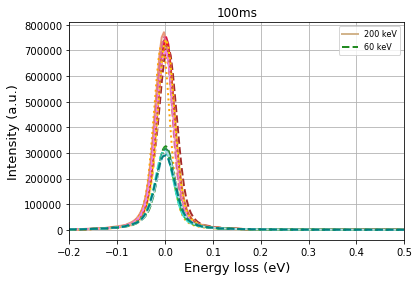

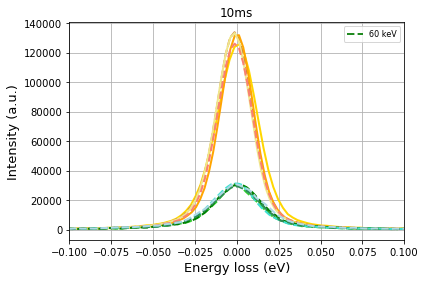

,x0,x1,x2,x3,x4,y0,y1,y2,y3,y4,time,energy
0,-0.746351,-0.709533,-0.675014,-0.694672,-0.673422,-482.2260,-403.7880,-424.410,-451.7850,-703.6880,10,200
1,-0.743452,-0.706799,-0.672443,-0.692015,-0.670867,648.7130,821.4990,952.905,674.4830,690.4970,10,200
2,-0.740554,-0.704064,-0.669871,-0.689358,-0.668311,-778.2360,-1185.7000,-725.496,-897.5780,-946.9150,10,200
3,-0.737655,-0.701330,-0.667300,-0.686702,-0.665756,81.2226,172.4970,671.286,16.7773,111.5060,10,200
4,-0.734757,-0.698596,-0.664729,-0.684045,-0.663200,155.9610,817.9910,545.909,529.7340,92.0555,10,200
...,...,...,...,...,...,...,...,...,...,...,...,...
2043,5.175357,4.876596,4.578429,4.732845,4.547600,-561.2010,-422.7600,-396.671,-684.2600,-860.4550,10,200
2044,5.178255,4.879330,4.581000,4.735502,4.550156,-771.2080,-187.8360,-338.211,-306.1240,-639.0300,10,200
2045,5.181154,4.882064,4.583571,4.738158,4.552711,-198.2660,42.9789,-337.384,-410.3230,-469.4970,10,200
2046,5.184052,4.884799,4.586143,4.740815,4.555267,-713.0260,-313.3830,-516.815,-197.8400,-935.8330,10,200


In [2]:
%run Data/Vacuum/EELS-ZLP-Mar.py

file10_200


In [3]:
file = file100_60
file_totaltot = pd.DataFrame()
fwhm_array = []

for i in range(0,5):
    x = file['x%(i)s'%{"i": i}]
    y = file['y%(i)s'%{"i": i}]
    file_total = pd.DataFrame()
    file_total['x'] = x
    file_total['y'] = y
    file_total['time'] = file['time']
    file_total['energy'] = file['energy']
    
    file_totaltot = pd.concat((file_totaltot, file_total), axis=0)
    


In [4]:
## Drop all data between FWHM and end

,x,y_norm,sigma,time,energy,rel_error,y
0,-0.100000,0.014640,0.002878,0.1,0.6,0.196570,0.111875
1,-0.094915,0.017189,0.002629,0.1,0.6,0.152936,0.114013
2,-0.089831,0.019153,0.002568,0.1,0.6,0.134072,0.115662
3,-0.084746,0.022845,0.004633,0.1,0.6,0.202780,0.118761
4,-0.079661,0.028819,0.004572,0.1,0.6,0.158631,0.123773


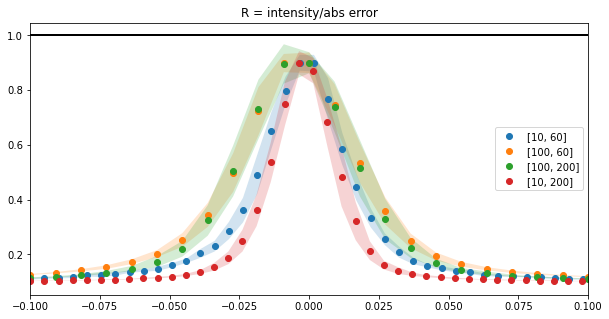

In [5]:
%run Functions
meanfile = pd.DataFrame()
from copy import copy
import copy
import scipy
mean = []
columns = ['x', 'y', 'time', 'energy']

file10_60 = pd.read_csv('Data/Vacuum/Datafiles/10_60_total.csv', skiprows = 1, names=columns)
file100_60 = pd.read_csv('Data/Vacuum/Datafiles/100_60_total.csv', skiprows = 1, names=columns)
file10_200 = pd.read_csv('Data/Vacuum/Datafiles/10_200_total.csv', skiprows = 1, names=columns)
file100_200= pd.read_csv('Data/Vacuum/Datafiles/100_200_total.csv', skiprows = 1, names=columns)

plt.figure(figsize=(10,5))
for i, file in enumerate([file10_60, file100_60, file100_200, file10_200]):
    E_min = -.1
    
    if file['time'].max() == 10:
        if file['energy'].max() == 200:
            E_max = min_x = .25
            nbins = 70
        if file['energy'].max() == 60:
            E_max = min_x = .2 
            nbins = 60
            
        max_x = 1
        
        N_pseudo = 120 - nbins
        
    if file['time'].max() == 100:
        E_max = .8
        min_x = .8
        max_x = 1
        nbins = 100
        N_pseudo = 120 - nbins
   
    window_file = file[(file['x'] > E_min) & (file['x'] < E_max)]
    
    ## Transform the data for scaling
    window_file['y_norm'] = np.divide(window_file['y'], window_file['y'].max())
    
    window_file['y_scaled'] = (window_file['y_norm'])*((8/9))+.1
    
        
    meanfile = pd.DataFrame()
    meanfile['x'] = np.linspace(E_min, E_max, nbins)
    meanfile['y_norm'] = binned_statistics(window_file['x'], window_file['y_norm'], nbins)[0]
    meanfile['sigma'] = binned_statistics(window_file['x'], window_file['y_norm'], nbins)[1]
    meanfile['time'] = file['time'].max()/100
    meanfile['energy'] = file['energy'].max()/100
    meanfile['rel_error'] = np.divide(meanfile['sigma'], meanfile['y_norm'])
    
    ### Scaler
    from sklearn.preprocessing import MinMaxScaler
    
    
    time = meanfile['time'].max()
    energy = meanfile['energy'].max()
    
    df_pseudo = pd.DataFrame({'x':np.linspace(min_x, max_x, N_pseudo),'y_norm': 0.001 * np.ones(N_pseudo), \
                        'sigma': 0.0001 * np.ones(N_pseudo), 'time': time, 'energy': energy})

    df_full = pd.concat([meanfile, df_pseudo])
    scaler = MinMaxScaler(feature_range=(.1, .9))
    to_scale = df_full['y_norm'].to_numpy().reshape(-1,1)
    scaler.fit(to_scale)
    
    df_full['y'] = scaler.transform(to_scale)
    
    
    plt.plot(df_full['x'], df_full['y'], 'o', label=[file['time'].max(), file['energy'].max()])
    plt.axhline(y=1, linestyle='-', color='black')
    plt.legend()
    plt.fill_between(df_full['x'], df_full['y']+df_full['sigma'],df_full['y']-df_full['sigma'], alpha=.2)
    plt.xlim([-.1, .1])
    plt.title('R = intensity/abs error')
    
    mean.append(df_full)
total_mean = pd.concat(mean, axis=0, ignore_index=True)
total_mean.head()

### Create architecture

In [6]:
def make_model(inputs, n_outputs):
    hidden_layer_1 = tf.layers.dense(inputs, 10, activation=tf.nn.sigmoid)
    hidden_layer_2 = tf.layers.dense(hidden_layer_1, 15, activation=tf.nn.sigmoid)
    hidden_layer_3 = tf.layers.dense(hidden_layer_2, 5, activation=tf.nn.sigmoid)
    #hidden_layer_3 = tf.layers.dropout(hidden_layer_3, 0.15)
    output = tf.layers.dense(hidden_layer_3, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)
    return output



### Prepare data for training

Cost function: $\chi^2 = 1/N \sum (y - y_{pred})^2 / \sigma^2$ \
Optimizer: AdamOptimizer, $\eta = 0.02$\

Training points are generated by Monte Carlo sampling; for the set of training points $[dE, D_i, \sigma_i]$, a set of MC training points is generated by adding a stochastic noise signal on top of the the data with a std equal to the corresponding error on that point. 

- **train_x**: $[dE, t_{exp}]$
- **train_y**: $D_i$ + rand.norm(0, $\sigma_i$)

Repetitive training of the NN (number of repetitions = $N_{rep}$) on each set of MC pseudo data yields a prediction that is distributed with a mean and std corresponding to the mean and error of the original training set. 


In [7]:
tf.compat.v1.get_default_graph
from copy import copy
from sklearn.model_selection import train_test_split
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 


x = tf.placeholder("float", [None, 3], name="x")
y = tf.placeholder("float", [None, 1], name="y")
sigma = tf.placeholder("float", [None, 1], name="sigma")

df_full = total_mean
df_full = df_full.sort_values(by='x')
predictions = make_model(x,1)

df_full.describe()

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


,x,y_norm,sigma,time,energy,rel_error,y
count,480.000000,480.000000,480.000000,480.000000,480.00000,330.000000,480.000000
mean,0.378125,0.053898,0.006229,0.550000,1.30000,0.311424,0.145819
std,0.325704,0.169067,0.017761,0.450469,0.70073,0.359550,0.144463
min,-0.100000,0.000062,0.000058,0.100000,0.60000,0.030345,0.100000
25%,0.092292,0.001000,0.000100,0.100000,0.60000,0.118503,0.100428
50%,0.326902,0.001000,0.000196,0.550000,1.30000,0.196926,0.100653
75%,0.661579,0.010263,0.001749,1.000000,2.00000,0.379823,0.108371
max,1.000000,0.953779,0.108651,1.000000,2.00000,4.228076,0.900000


In [8]:
df_train, df_test = train_test_split(df_full, test_size=0.2)

cols=[ 'x', 'time', 'energy', 'sigma']
train_inputs = df_train.drop(['y'], axis=1)[cols]
train_outputs = df_train['y']
test_inputs = df_test.drop(['y'], axis=1)[cols]
test_outputs = df_test['y']

train_x = train_inputs.drop('sigma', axis=1).to_numpy()
train_y = train_outputs.to_numpy()
train_sigma = train_inputs['sigma'].to_numpy()
test_x = test_inputs.drop('sigma', axis=1).to_numpy()
test_y = test_outputs.to_numpy()
test_sigma = test_inputs['sigma'].to_numpy()

df_test.describe()

train_sigma.shape


(384,)

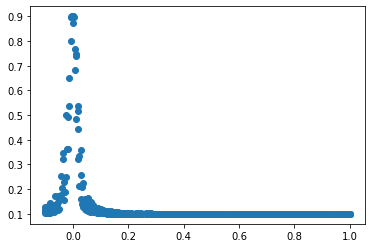

In [9]:
plt.plot(train_inputs['x'], train_outputs, 'o')

## Create MC replicas

In [10]:
### Create array of Nrep training samples
Nrep = 5000
N_train = len(train_y)
N_test = len(test_y)

train_y_reps = np.zeros(shape=(N_train, Nrep))
test_y_reps = np.zeros(shape=(N_test, Nrep))
i=0
while i < Nrep:
        train_rep = np.random.normal(0, train_sigma)
        test_rep = np.random.normal(0, test_sigma)
        train_y_reps[:,i] = (train_y + train_rep).reshape(N_train)
        test_y_reps[:,i] = (test_y + test_rep).reshape(N_test)
        i+=1 
        
std_reps = np.std(train_y_reps, axis=1)
mean_reps = np.mean(train_y_reps, axis=1)



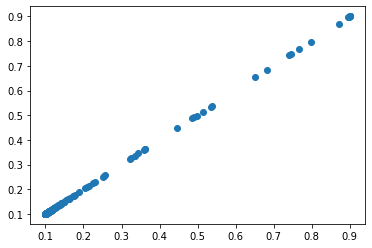

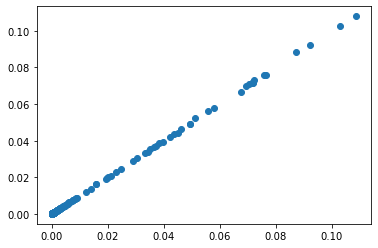

In [11]:
plt.plot(train_y, mean_reps, 'o')
plt.show()
plt.plot(train_sigma, std_reps, 'o')

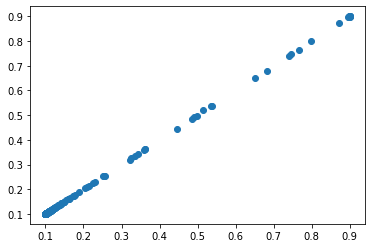

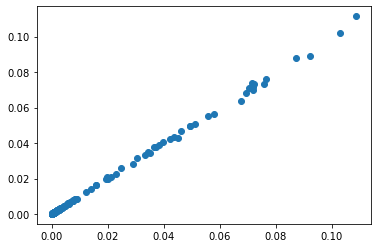

In [12]:
Nrep = 1000

train_y_reps = np.zeros(shape=(N_train, Nrep))
test_y_reps = np.zeros(shape=(N_test, Nrep))
i=0
while i < Nrep:
        train_rep = np.random.normal(0, train_sigma)
        test_rep = np.random.normal(0, test_sigma)
        train_y_reps[:,i] = (train_y + train_rep).reshape(N_train,)
        test_y_reps[:,i] = (test_y + test_rep).reshape(N_test,)
        i+=1 
        
std_reps = np.std(train_y_reps, axis=1)
mean_reps = np.mean(train_y_reps, axis=1)

train_sigma.shape
plt.plot(train_y, mean_reps, 'o')
plt.show()
plt.plot(train_sigma, std_reps, 'o')
plt.show()


In [14]:
import time
from datetime import datetime
now = datetime.now()
import tensorflow.compat.v1 as tf

def function_train(it):
    import tensorflow.compat.v1 as tf
    
    chi_array = []
    
    processor = 'processor' + str(it)
    cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="cost_function")
    custom_cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="custom_cost_function")
    eta = 4e-2

    #optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate=eta, decay=0.9, momentum=0.0, epsilon=1e-10).minimize(cost)
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=eta, beta1=0.9, beta2=0.999, epsilon=1e-08).minimize(cost)

    saver = tf.compat.v1.train.Saver(max_to_keep=10000)
    print("%(p)s starts training on" %{'p': processor}, '%04d' %(N_train), "and validating on", '%0.4d' %(N_test), "samples")
    
    Nrep = 500

    for i in range(133,500):
        train_y = train_y_reps[:, i + it].reshape(N_train,1)
        test_y = test_y_reps[:, i + it].reshape(N_test,1)
        
        train_y_og = train_outputs.to_numpy().reshape(N_train,1)
        test_y_og = test_outputs.to_numpy().reshape(N_test,1)
        
        ### Train and validate
        prev_test_cost = 100
        prev_epoch=0
        avg_cost = 0.0

        array_train = []
        array_test = []
        chi_train = []
        chi_test = []

        with tf.compat.v1.Session() as sess:
 
            sess.run(tf.global_variables_initializer())
            
            training_epochs = 40000
            max_rising_epochs = 50000 #The amount of epochs the minimzer is allowed to overfit before it stops
            display_step = 1000

            for epoch in range(training_epochs):

                _, c = sess.run([optimizer, cost], 
                                feed_dict={
                                    x: train_x,
                                    y: train_y,
                                    sigma: train_sigma.reshape(N_train,1)
                                })

                avg_cost = c

                test_cost = cost.eval({x: test_x, y: test_y, sigma: test_sigma.reshape(N_test,1)})
                avg_chi = cost.eval({x: train_x, y: train_y_og, sigma: train_sigma.reshape(N_train,1)})
                test_chi = cost.eval({x: test_x, y: test_y_og, sigma: test_sigma.reshape(N_test,1)})


                if epoch % display_step == 0:
                    print("Epoch:", '%04d' % (epoch+1), "| Training cost=", "{:.9f}".format(avg_cost), "| Validation cost=", "{:.9f}".format(test_cost))
        
                    array_train.append(avg_cost)
                    array_test.append(test_cost)
                    chi_train.append(avg_chi)
                    chi_test.append(test_chi)
                    
                    saver.save(sess, 'Models/%(processor)s/my-model.ckpt' %{'processor': processor} , global_step=epoch , write_meta_graph=False) 

                    
                elif test_cost < prev_test_cost:
                    prev_test_cost = test_cost
                    prev_epoch = epoch

            best_iteration = np.argmin(array_test) 
            best_epoch = best_iteration * display_step
            best_model = 'Models/%(processor)s/my-model.ckpt-%(s)s' % {'processor': processor, 's': best_epoch}

            print("Optimization %(i)s Finished! Best model after epoch %(s)s" % {'i': i, 's': best_epoch})
            
            dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
            d_string = '31.08.2020'
            t_string = now.strftime("%H:%M:%S")
            print(d_string)
            
            saver.restore(sess, best_model)
            saver.save(sess, 'Models/Best_model/%(s)s/x1_processor%(it)s_%(i)s' % {'s': d_string, 'it': it, 'i': i})


            predictions_values_train = sess.run(predictions, 
                                feed_dict={
                                    x: train_x,
                                    y: train_y 
                                }) 
            predictions_values_test = sess.run(predictions, 
                                feed_dict={
                                    x: test_x,
                                    y: test_y 
                                }) 
            
           

        sess.close()

        a1 = np.array(train_x[:,0]).reshape(N_train,)
        b1 = np.array(train_x[:,1]).reshape(N_train,)
        c1 = np.array(train_x[:,2]).reshape(N_train,)
        d1 = np.array(train_y).reshape(N_train,)
        e1 = np.array(train_sigma).reshape(N_train,)
        f1 = np.array(predictions_values_train).reshape(N_train,)
        g1 = np.array(train_y_og).reshape(N_train,)
        
        f = array_train
        g = array_test
        
        a2 = np.array(test_x[:,0]).reshape(N_test,)
        b2 = np.array(test_x[:,1]).reshape(N_test,)
        c2 = np.array(test_x[:,2]).reshape(N_test,)
        d2 = np.array(test_y).reshape(N_test,)
        e2 = np.array(test_sigma).reshape(N_test,)
        f2 = np.array(predictions_values_test).reshape(N_test,)
        g2 = np.array(test_y_og).reshape(N_test,)
       
        o = chi_train
        p = chi_test
        
        
        np.savetxt('Data/Results/Vacuum/%(date)s/x1_xyp1p2_e%(epoch)s_%(i)s.csv' % {"date": d_string, "epoch": processor, "i": i}, list(zip(a1,b1,c1,d1,e1,f1,g1)),  delimiter=',',fmt='%f')
        np.savetxt('Data/Results/Vacuum/%(date)s/x1_xyp3p4_e%(epoch)s_%(i)s.csv' % {"date": d_string, "epoch": processor, "i": i}, list(zip(a2,b2,c2,d2,e2,f2, g2)),  delimiter=',',fmt='%f')
        
        np.savetxt('Data/Results/Vacuum/%(date)s/x1_chi_e%(epoch)s_%(i)s.csv' % {"date": d_string, "epoch": processor, "i": i}, list(zip(f,g)),  delimiter=',',fmt='%f')
        np.savetxt('Data/Results/Vacuum/%(date)s/x1_chivalues_e%(epoch)s_%(i)s.csv' % {"date": d_string, "epoch": processor, "i": i}, list(zip(o,p)),  delimiter=',', fmt='%f')
 

In [15]:
function_train(1)


processor1 starts training on 0384 and validating on 0096 samples
Epoch: 0001 | Training cost= 2172762.750000000 | Validation cost= 1795363.375000000
Epoch: 1001 | Training cost= 32.973876953 | Validation cost= 23.081151962
Epoch: 2001 | Training cost= 32.351703644 | Validation cost= 22.443090439
Epoch: 3001 | Training cost= 32.323665619 | Validation cost= 22.303827286
Epoch: 4001 | Training cost= 32.995372772 | Validation cost= 46.221721649
Epoch: 5001 | Training cost= 32.596206665 | Validation cost= 22.643701553
Epoch: 6001 | Training cost= 785.446350098 | Validation cost= 749.632263184
Epoch: 7001 | Training cost= 718.915283203 | Validation cost= 111.588653564
Epoch: 8001 | Training cost= 32.602172852 | Validation cost= 22.648284912
Epoch: 9001 | Training cost= 34.169906616 | Validation cost= 23.121658325
Epoch: 10001 | Training cost= 33.066356659 | Validation cost= 24.705026627
Epoch: 11001 | Training cost= 687.418273926 | Validation cost= 226.832992554
Epoch: 12001 | Training cost

KeyboardInterrupt: 

## File with 120keV predictions

predict = []
time = [.1, 1]

for i, energy in enumerate([.6, 1.2, 2]):
    for j in range(2):
        E_min = -.1
        E_max = .1
        nbins = 100
        meanfile = pd.DataFrame()
        meanfile['x'] = np.linspace(E_min, E_max, nbins)
        meanfile['time'] = time[j]
        meanfile['energy'] = energy
    
        predict.append(meanfile)

    
predict_x = pd.concat(predict, axis=0, ignore_index=True)
predict_x.describe()



## File with e_loss extrapolation

In [16]:
predict = []
time = [.1, 1]

for i, energy in enumerate([.6, 2]):
    for j in range(2):
        E_min = -.1
        E_max = 1
        nbins = 1000
        meanfile = pd.DataFrame()
        meanfile['x'] = np.linspace(E_min, E_max, nbins)
        meanfile['time'] = time[j]
        meanfile['energy'] = energy
    
        predict.append(meanfile)

    
predict_x = pd.concat(predict, axis=0, ignore_index=True)
predict_x.describe()


,x,time,energy
count,4000.0000,4000.000000,4000.000000
mean,0.4500,0.550000,1.300000
std,0.3179,0.450056,0.700088
min,-0.1000,0.100000,0.600000
25%,0.1750,0.100000,0.600000
50%,0.4500,0.550000,1.300000
75%,0.7250,1.000000,2.000000
max,1.0000,1.000000,2.000000


## File with beam energy extrapolation

predict = []
time = [.1, 1]
for i, energy in enumerate(np.linspace(0, 350, 36)):
    
    for j in range(2):
        E_min = -.1
        E_max = .1
        nbins = 1000
        meanfile = pd.DataFrame()
        meanfile['x'] = np.linspace(E_min, E_max, nbins)
        meanfile['time'] = time[j]
        meanfile['energy'] = energy/100
    
        predict.append(meanfile)

    
predict_x = pd.concat(predict, axis=0, ignore_index=True)
predict_x.describe()


## File with time extrapolation

predict = []
energy = [.6, 2]

for i, time in enumerate(np.linspace(0, 200, 21)):
    
    for j in range(2):
        E_min = -.1
        E_max = 1
        nbins = 1000
        meanfile = pd.DataFrame()
        meanfile['x'] = np.linspace(E_min, E_max, nbins)
        meanfile['time'] = time/100
        meanfile['energy'] = energy[j]
    
        predict.append(meanfile)

    
predict_x = pd.concat(predict, axis=0, ignore_index=True)
predict_x.describe()


In [17]:
prediction_file = pd.DataFrame()
prediction_file['x'] = predict_x['x']
prediction_file['time'] = predict_x['time']
prediction_file['energy'] = predict_x['energy']
good_files = np.loadtxt('Data/good_files_cut_full')



In [18]:
d_string = '29.08.2020'

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(0,392):

        if good_files[i] == 1:
            best_model = 'Models/Best_model/%(s)s/x1_processor%(it)s_%(i)s'% {'s': d_string, 'it': j, 'i': i}
            saver = tf.compat.v1.train.Saver(max_to_keep=1000)
            saver.restore(sess, best_model)

            extrapolation = sess.run(predictions,
                                    feed_dict={
                                    x: predict_x
                                    })

            prediction_file['prediction_%(j)s_%(i)s' % {"j": j, "i": i}] = extrapolation
            

INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_0
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_1
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_2
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_4
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_5
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_6
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_7
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_8
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_9
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_10
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_11
INFO:tensorflow:Restoring parameters from

INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_116
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_117
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_118
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_119
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_120
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_121
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_123
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_125
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_126
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_128
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_129
INFO:tensorflow:Resto

INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_226
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_227
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_228
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_229
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_230
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_231
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_233
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_235
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_236
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_237
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_238
INFO:tensorflow:Resto

INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_342
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_343
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_345
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_346
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_347
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_348
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_349
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_350
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_351
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_352
INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_353
INFO:tensorflow:Resto

## Energy extrapolation plot

In [19]:
prediction_file.to_csv('Data/Energy_extrapolation_cut_big')

In [50]:
energy_file = pd.read_csv('Data/interpolation_120keV_full')
import matplotlib

energy_file.head()

energy_file_rescaled = energy_file.copy()
scaler = MinMaxScaler(feature_range=(0, 1))
to_scale = energy_file.iloc[:, 4:]
scaler.fit(to_scale)
    
arrays_rescaled = scaler.transform(to_scale)

energy_file_rescaled.iloc[:, 4:] = arrays_rescaled

energy_file_rescaled.describe()

,Unnamed: 0,x,time,energy,prediction_1_0,prediction_1_1,prediction_1_2,prediction_1_4,prediction_1_5,prediction_1_6,...,prediction_1_486,prediction_1_487,prediction_1_488,prediction_1_489,prediction_1_491,prediction_1_493,prediction_1_494,prediction_1_495,prediction_1_496,prediction_1_498
count,600.000000,6.000000e+02,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,...,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,299.500000,-2.081668e-19,0.550000,1.266667,0.209926,0.196385,0.206096,0.184348,0.206827,0.201884,...,0.189077,0.218582,0.965569,0.117117,0.233251,0.158380,0.202818,0.933583,0.202444,0.210631
std,173.349358,5.836395e-02,0.450375,0.573967,0.287240,0.274005,0.282484,0.257109,0.275615,0.270896,...,0.270533,0.290963,0.122037,0.188954,0.311202,0.273310,0.279646,0.189130,0.280197,0.283718
min,0.000000,-1.000000e-01,0.100000,0.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,149.750000,-5.000000e-02,0.100000,0.600000,0.019515,0.019065,0.023473,0.020363,0.021777,0.019905,...,0.020095,0.021613,0.993426,0.009493,0.022293,0.005733,0.018116,0.995432,0.019860,0.020644
50%,299.500000,-6.938894e-18,0.550000,1.200000,0.054974,0.050834,0.059726,0.050180,0.063818,0.059033,...,0.052593,0.066789,0.997633,0.023885,0.066082,0.022960,0.055358,0.999878,0.056145,0.058971
75%,449.250000,5.000000e-02,1.000000,2.000000,0.295148,0.267735,0.272696,0.235143,0.289036,0.284885,...,0.229591,0.298860,0.998641,0.137216,0.330596,0.139153,0.276117,0.999981,0.258709,0.297814
max,599.000000,1.000000e-01,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


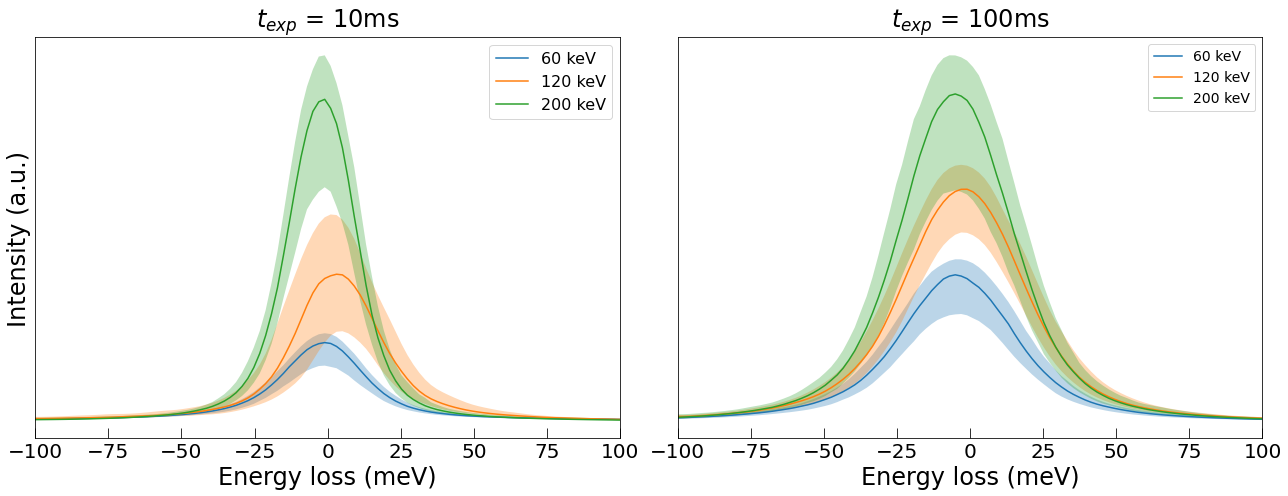

In [66]:
groups_full = energy_file_rescaled.groupby(['time', 'energy'])

ncols, nrows = 2,1

gs = matplotlib.gridspec.GridSpec(nrows,ncols)
plt.figure(figsize=(ncols*9,nrows*7))

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])


interpolation_file = pd.DataFrame()

for name, group in groups_full:
    mean_prediction = group.iloc[:, 4:].median(axis=1).to_numpy()
    up_prediction = group.iloc[:, 4:].quantile(.84, axis=1).to_numpy()
    down_prediction = group.iloc[:, 4:].quantile(.16, axis=1).to_numpy()
    
    if group['energy'].max() == 1.2:
        up_prediction = group.iloc[:, 4:].quantile(.7, axis=1).to_numpy()
        down_prediction = group.iloc[:, 4:].quantile(.3, axis=1).to_numpy()
        mean_prediction = smooth(mean_prediction, 6)
        down_prediction = smooth(down_prediction, 6)
        up_prediction = smooth(up_prediction, 6)      
    
    if group['time'].max() == .1:
        if group['energy'].max() == .6:
            normalization = 29211
        if group['energy'].max() == 2:
            normalization = 126021
        if group['energy'].max() == 1.2:
            normalization = 77616
    

        ax = ax1
        ax.set_title('$t_{exp}$ = 10ms', fontsize = 24)
        ax.set_ylabel('Intensity (a.u.)', fontsize = 24)  
        ax.set_xlabel('Energy loss (meV)', fontsize = 24) 
        ax.set_yticks([])
        ax.tick_params(which='major',direction='in',length=10, labelsize=20)
        ax.tick_params(which='minor',length=10, labelsize=20)
        ax.set_xlim([-100, 100])
        ax.plot(group.x*1000, normalization*mean_prediction, label=(str(int(name[1]*100)))+' keV')
        ax.fill_between(group.x*1000, normalization*up_prediction, \
                        normalization*down_prediction, alpha=.3) 
        ax.legend(loc='upper right', fontsize=16)
    if group['time'].max() == 1:
        if group['energy'].max() == .6:
            normalization = 315762
        if group['energy'].max() == 2:
            normalization =  713038   
        if group['energy'].max() == 1.2:
            normalization = 514400
        ax = ax2
        ax.set_title('$t_{exp}$ = 100ms', fontsize = 24)
        ax.set_xlabel('Energy loss (meV)', fontsize = 24) 
        ax.set_yticks([])
        ax.tick_params(which='major',direction='in',length=10, labelsize=20)
        ax.tick_params(which='minor',length=10, labelsize=20)
        ax.set_xlim([-100, 100])
        ax.plot(group.x*1000, normalization*(mean_prediction), label=(str(int(name[1]*100)))+' keV')
        ax.fill_between(group.x*1000, normalization*up_prediction, \
                        normalization*down_prediction, alpha=.3) 

ax.legend(fontsize = 14, loc = 'upper right')

plt.tight_layout()

#plt.savefig('Data/Prediction_120keV.pdf')

In [20]:
energy_file_cut = pd.read_csv('Data/Energy_extrapolation_cut_big')
energy_file_cut.describe()

,Unnamed: 0,x,time,energy,prediction_1_0,prediction_1_1,prediction_1_2,prediction_1_4,prediction_1_5,prediction_1_6,...,prediction_1_381,prediction_1_382,prediction_1_383,prediction_1_384,prediction_1_385,prediction_1_386,prediction_1_387,prediction_1_389,prediction_1_390,prediction_1_391
count,4000.000000,4000.0000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,1999.500000,0.4500,0.550000,1.300000,0.135957,0.136443,0.128438,0.139548,0.135699,0.100870,...,0.134276,0.136708,0.136436,0.136042,0.134824,0.134466,0.133925,0.101691,0.134722,0.135097
std,1154.844867,0.3179,0.450056,0.700088,0.126854,0.134902,0.057804,0.135296,0.129587,0.000241,...,0.122980,0.136040,0.126379,0.135309,0.127943,0.128608,0.123449,0.000810,0.128148,0.129571
min,0.000000,-0.1000,0.100000,0.600000,0.100355,0.100471,0.100354,0.100371,0.100507,0.100431,...,0.100060,0.100398,0.100557,0.100387,0.100203,0.100424,0.100280,0.100163,0.100447,0.100456
25%,999.750000,0.1750,0.100000,0.600000,0.100685,0.100647,0.100661,0.100815,0.100664,0.100644,...,0.100658,0.100677,0.100632,0.100678,0.100680,0.100710,0.100683,0.101008,0.100631,0.100682
50%,1999.500000,0.4500,0.550000,1.300000,0.100840,0.100802,0.100834,0.101961,0.100916,0.100906,...,0.100730,0.100947,0.101046,0.100789,0.100832,0.100846,0.100824,0.101622,0.100814,0.100935
75%,2999.250000,0.7250,1.000000,2.000000,0.107634,0.101943,0.104978,0.115370,0.105265,0.101114,...,0.103008,0.105797,0.107933,0.101231,0.104051,0.101455,0.102158,0.102330,0.101545,0.104437
max,3999.000000,1.0000,1.000000,2.000000,0.943853,1.021314,0.272666,1.035522,0.983327,0.101169,...,0.940423,1.102383,0.952517,1.124858,0.982519,0.981408,0.911188,0.103638,0.961433,0.984873


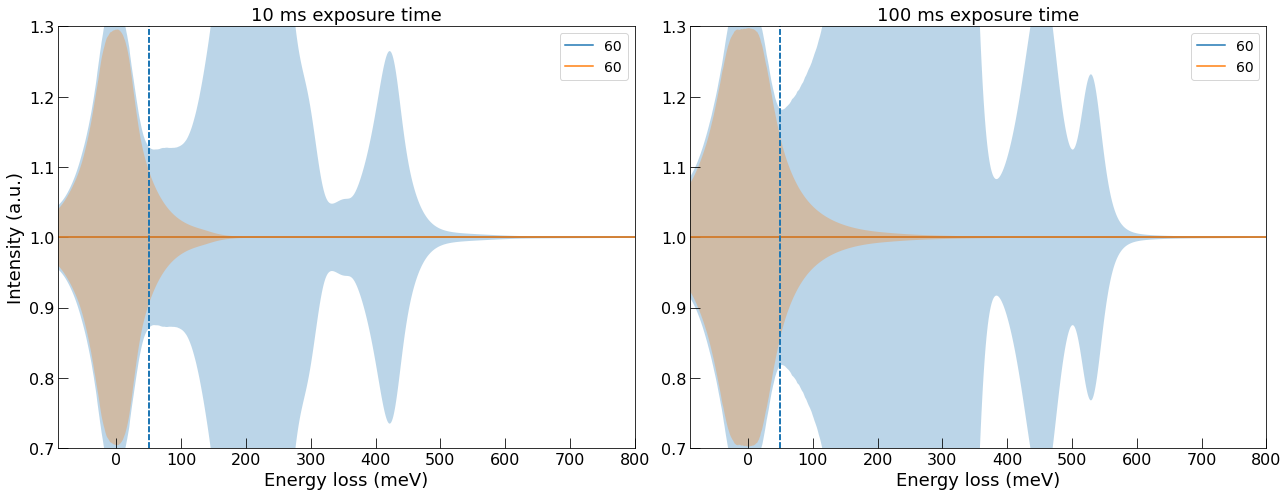

In [28]:
groups_cut = energy_file_cut.groupby(['time', 'energy'])
energy_file_full = pd.read_csv('Data/Energy_extrapolation_full')
groups_full = energy_file_full.groupby(['time', 'energy'])

import matplotlib

ncols, nrows = 2,1
gs = matplotlib.gridspec.GridSpec(nrows,ncols)

plt.figure(figsize=(ncols*9,nrows*7))

groups_total = [groups_cut, groups_full]

for i in range(2):
    groups = groups_total[i]
    
    for name, group in groups:
        mean_prediction = group.iloc[:, 4:].median(axis=1).to_numpy()
        std_prediction = group.iloc[:, 4:].std(axis=1).to_numpy()
        up_prediction = group.iloc[:,4:].quantile(.8, axis=1).to_numpy()
        down_prediction = group.iloc[:,4:].quantile(.2, axis=1).to_numpy()

        if group['time'].max() == .1 and group['energy'].max() == .6:
            i = 0
            ax = plt.subplot(gs[i])
            ax.set_title('10 ms exposure time', fontsize = 18)
            ax.set_ylabel('Intensity (a.u.)', fontsize = 18)
            #ax.set_ylim([0, 1])
            ax.plot(group.x*1000, np.divide(mean_prediction, mean_prediction), label=int(name[1] * 100))
            ax.tick_params(which='major',direction='in',length=10, labelsize=16)
            ax.fill_between(group.x*1000, np.divide(mean_prediction + std_prediction, mean_prediction), \
                            np.divide(mean_prediction - std_prediction, mean_prediction), alpha=.3)

        if group['time'].max() == 1 and group['energy'].max() == .6:
            i = 1
            ax = plt.subplot(gs[i])
            #ax.set_ylim([0, 1.2])
            ax.set_title('100 ms exposure time', fontsize = 18)
            ax.plot(group.x*1000, np.divide(mean_prediction, mean_prediction), label=int(name[1] * 100))
            ax.fill_between(group.x*1000, np.divide(mean_prediction + std_prediction, mean_prediction), \
                            np.divide(mean_prediction - std_prediction, mean_prediction), alpha=.3)
            ax.tick_params(which='major',direction='in',length=10, labelsize=16)
        plt.xlim([-90, +800])
        plt.ylim([0.7, 1.3])

        plt.xlabel('Energy loss (meV)', fontsize = 18)
        plt.axvline(x=50, linestyle='--')

        plt.legend(fontsize = 14)
    plt.tight_layout()
plt.savefig('Data/Energy_extrapolation_big_cut_60.pdf')

## E_beam extrapolation plot

In [21]:
ebeam_file = pd.read_csv('Data/Prediction_vacuum_Ebeam_350')

In [27]:
groups_time = ebeam_file.groupby(['time'])

for name, group in groups_time:
    groups_energy = group.groupby(['energy'])
    fwhm_means = []
    fwhm_stds = []
    max_means = []
    max_stds = []
    fwhm_ups = []
    fwhm_downs = []
    
    for name_energy, group_energy in groups_energy:
        fwhm_array = []
        max_array = []
        
        
        for i in range(4,400):
            prediction = pd.DataFrame({"x": group_energy.x, "pred": group_energy.iloc[:,i]})
            max_x = prediction['x'][prediction['pred'] == prediction['pred'].max()].min()
            fwhm_min = prediction['x'][(prediction['x'] < 0) & (prediction['pred'].max() > .25) & \
                                   (prediction['pred'] > prediction['pred'].max()/2)].min()
            fwhm_max = prediction['x'][(prediction['x'] > 0) & (prediction['pred'].max() > .25) & \
                                   (prediction['pred'] < prediction['pred'].max()/2)].min()
            fwhm = (fwhm_max - fwhm_min)
            fwhm_array.append(fwhm)
            
        # Remove nan values  
        fwhm_array = [x for x in fwhm_array if str(x) != 'nan']
        
        
        fwhm_mean = np.median(fwhm_array)
        fwhm_std = np.std(fwhm_array)
        fwhm_up = np.quantile(fwhm_array, 0.84)
        fwhm_down = np.quantile(fwhm_array, 0.16)
        fwhm_means.append(fwhm_mean)
        fwhm_stds.append(fwhm_std)
        fwhm_ups.append(fwhm_up)
        fwhm_downs.append(fwhm_down)
       
        fwhm_high = fwhm_ups
        fwhm_low = fwhm_downs
      
        np.savetxt('Data/Results/fwhmvalues350_mean_%(s)s' % {"s": name}, fwhm_means)
        np.savetxt('Data/Results/fwhmvalues350_std_%(s)s' % {"s": name}, fwhm_stds)
        np.savetxt('Data/Results/fwhmvalues350_up_%(s)s' % {"s": name}, fwhm_ups)
        np.savetxt('Data/Results/fwhmvalues350_down_%(s)s' % {"s": name}, fwhm_downs)

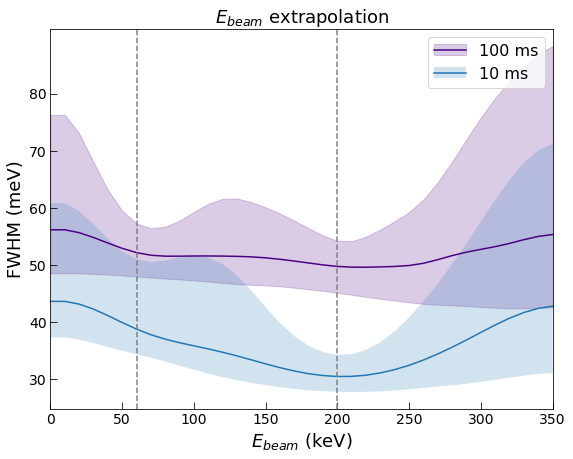

In [30]:
from matplotlib import rc
import matplotlib

fwhmvalues_mean_100 = np.loadtxt('Data/Results/fwhmvalues350_mean_1.0')
fwhmvalues_mean_10 = np.loadtxt('Data/Results/fwhmvalues350_mean_0.1')
up100 = np.loadtxt('Data/Results/fwhmvalues350_up_1.0')
up10 = np.loadtxt('Data/Results/fwhmvalues350_up_0.1')
low100 = np.loadtxt('Data/Results/fwhmvalues350_down_1.0')
low10 = np.loadtxt('Data/Results/fwhmvalues350_down_0.1')


hfont = rc('font',**{'family':'sans-serif','sans-serif':['Sans Serif']})

nrows, ncols = 1,1

gs = matplotlib.gridspec.GridSpec(nrows,ncols)
wl = 8

color2 = 'indigo'
plt.figure(figsize=(ncols*9,nrows*7))
ax = plt.subplot(gs[0])
ax.plot(np.linspace(0,350,36), smooth(fwhmvalues_mean_100 * 1000, wl), color = color2, label = '100 ms')
ax.fill_between(np.linspace(0,350,36), smooth(up100 * 1000, wl), smooth(low100 * 1000, wl), color = color2, alpha=.2, label = '100 ms')
ax.plot(np.linspace(0,350,36), smooth(fwhmvalues_mean_10 * 1000, wl*2), label = '10 ms')
ax.fill_between(np.linspace(0,350,36), smooth(up10 * 1000, wl*2), smooth(low10 * 1000, wl),  alpha=.2, label = '10 ms')
ax.axvline(x=60, linestyle='--', color='gray')
ax.axvline(x=200, linestyle='--', color='gray')
ax.tick_params(which='major',direction='in',length=7, labelsize=14)
ax.tick_params(which='minor',length=8, labelsize=14)
ax.set_yticks([30, 40, 50, 60, 70, 80])
ax.set_ylabel('FWHM (meV)', fontsize = 18)
ax.set_xlim([0, 350])
ax.set_xlabel('$E_{beam}$ (keV)', fontsize = 18)
lables, handles = ax.get_legend_handles_labels() 
ax.legend([(lables[0], lables[2]), (lables[1], lables[3])], [(handles[0]), handles[1]], loc='upper right', fontsize=16)
ax.set_title('$E_{beam}$ extrapolation', fontsize=18)
plt.savefig('Ebeam_extrapolation_350.pdf')


## Time extrapolation plot

In [20]:
time_file = pd.read_csv('Data/Prediction_vacuum_time')

In [21]:
groups_energy = time_file.groupby(['energy'])

for name, group in groups_energy:
    groups_time = group.groupby(['time'])
    fwhm_means = []
    fwhm_stds = []
    max_means = []
    max_stds = []
    fwhm_ups = []
    fwhm_downs = []
    
    for name_time, group_time in groups_time:
        fwhm_array = []
        max_array = []
        

        for i in range(4,400):
            prediction = pd.DataFrame({"x": group_time.x, "pred": group_time.iloc[:,i]})
            max_x = prediction['x'][prediction['pred'] == prediction['pred'].max()].min()
            fwhm_min = prediction['x'][(prediction['x'] < 0) & (prediction['pred'].max() > .25) & \
                                   (prediction['pred'] > prediction['pred'].max()/2)].min()
            fwhm_max = prediction['x'][(prediction['x'] > 0) & (prediction['pred'].max() > .25) & \
                                   (prediction['pred'] < prediction['pred'].max()/2)].min()
            fwhm = (fwhm_max - fwhm_min)

            fwhm_array.append(fwhm)
            
        # Remove nan values  
        fwhm_array = [x for x in fwhm_array if str(x) != 'nan']
        
        
        fwhm_mean = np.median(fwhm_array)
        fwhm_std = np.std(fwhm_array)
        fwhm_up = np.quantile(fwhm_array, 0.84)
        fwhm_down = np.quantile(fwhm_array, 0.16)
        fwhm_means.append(fwhm_mean)
        fwhm_stds.append(fwhm_std)
        fwhm_ups.append(fwhm_up)
        fwhm_downs.append(fwhm_down)
      
        np.savetxt('Data/Results/fwhmvalues_time_mean_%(s)s' % {"s": name}, fwhm_means)
        np.savetxt('Data/Results/fwhmvalues_time_std_%(s)s' % {"s": name}, fwhm_stds)
        np.savetxt('Data/Results/fwhmvalues_time_up_%(s)s' % {"s": name}, fwhm_ups)
        np.savetxt('Data/Results/fwhmvalues_time_down_%(s)s' % {"s": name}, fwhm_downs)

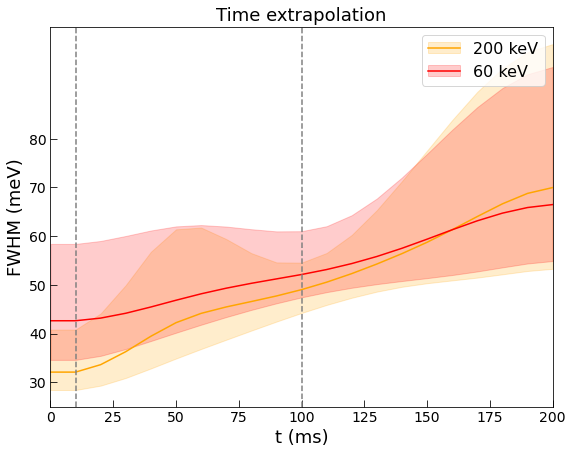

In [24]:
from matplotlib import rc
import matplotlib

fwhmvalues_mean_200 = np.loadtxt('Data/Results/fwhmvalues_time_mean_2.0')
fwhmvalues_mean_60 = np.loadtxt('Data/Results/fwhmvalues_time_mean_0.6')
up200 = np.loadtxt('Data/Results/fwhmvalues_time_up_2.0')
up60 = np.loadtxt('Data/Results/fwhmvalues_time_up_0.6')
low200 = np.loadtxt('Data/Results/fwhmvalues_time_down_2.0')
low60 = np.loadtxt('Data/Results/fwhmvalues_time_down_0.6')
fwhmvalues_std_200 = np.loadtxt('Data/Results/fwhmvalues_time_std_2.0')
fwhmvalues_std_60 = np.loadtxt('Data/Results/fwhmvalues_time_std_0.6')

hfont = rc('font',**{'family':'sans-serif','sans-serif':['Sans Serif']})

nrows, ncols = 1,1

gs = matplotlib.gridspec.GridSpec(nrows,ncols)
wl = 8
color1 = 'red'
color2 = 'orange'
plt.figure(figsize=(ncols*9,nrows*7))
ax = plt.subplot(gs[0])
ax.plot(np.linspace(0,200,21), smooth(fwhmvalues_mean_200 * 1000, wl), color = color2, label = '200 keV')
ax.fill_between(np.linspace(0,200,21), smooth(up200 * 1000, wl), smooth(low200 * 1000, wl), color = color2, alpha=.2, label = '200 keV')
ax.plot(np.linspace(0,200,21), smooth(fwhmvalues_mean_60 * 1000, wl*2), color=color1, label = '60 keV')
ax.fill_between(np.linspace(0,200,21), smooth(up60 * 1000, wl*2), smooth(low60 * 1000, wl), color=color1, alpha=.2, label = '60 keV')
ax.axvline(x=10, linestyle='--', color='gray')
ax.axvline(x=100, linestyle='--', color='gray')
ax.tick_params(which='major',direction='in',length=7, labelsize=14)
ax.tick_params(which='minor',length=8, labelsize=14)
ax.set_yticks([30, 40, 50, 60, 70, 80])
ax.set_ylabel('FWHM (meV)', fontsize = 18)
ax.set_xlim([0, 200])
ax.set_xlabel('t (ms)', fontsize = 18)
lables, handles = ax.get_legend_handles_labels() 
ax.legend([(lables[0], lables[2]), (lables[1], lables[3])], [(handles[0]), handles[1]], loc='upper right', fontsize=16)
ax.set_title('Time extrapolation', fontsize=18)
plt.savefig('Time_extrapolation_350.pdf')


## Residuals

## Write everything to report file

In [157]:
import sys
import base64

energy = 200
time = 10
nbins = 60
training_epochs = 100000

reportname = r'Reports/%(date)s_%(energy)skeV_%(time)sms_e%(epoch)s_Nrep=%(i)s.html' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
sys.stdout = open(reportname,'w')


from prettytable import PrettyTable
list1 = ['Energy:','Exposure time:','Nbins:', 'Replicas:', 'Training epochs:']
list2 = [energy, time, nbins, Nrep, training_epochs]

for x in range(0,5):
    print('%(s1)s %(s2)s <br />' % {"s1": list1[x], "s2": list2[x]}) 



In [ ]:
plot1 = r'Data/Results/%(date)s/aaa chidistribution_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot2 = r'Data/Results/%(date)s/aaa means-vs-means_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot3 = r'Data/Results/%(date)s/aaa std-vs-std_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot4 = r'Data/Results/%(date)s/aaa Residuals_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }

data_uri1 = base64.b64encode(open(plot1, 'rb').read()).decode('utf-8')
data_uri2 = base64.b64encode(open(plot2, 'rb').read()).decode('utf-8')
data_uri3 = base64.b64encode(open(plot3, 'rb').read()).decode('utf-8')
data_uri4 = base64.b64encode(open(plot4, 'rb').read()).decode('utf-8')
img_tag1 = '<img src="data:image/png;base64,{0}">'.format(data_uri1)
img_tag2 = '<img src="data:image/png;base64,{0}">'.format(data_uri2)
img_tag3 = '<img src="data:image/png;base64,{0}">'.format(data_uri3)
img_tag4 = '<img src="data:image/png;base64,{0}">'.format(data_uri4)

print(img_tag1)
print(img_tag2)
print(img_tag3)
print(img_tag4)